# Model experiments for Animals classification

In [1]:
from enum import Enum
from pathlib import Path
from typing import Any
from dataclasses import dataclass
import PIL
import json

import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.io import decode_image

## Dataset

In [2]:
class EnglishLabel(str, Enum):
    DOG = "dog"
    HORSE = "horse"
    ELEPHANT = "elephant"
    BUTTERFLY = "butterfly"
    CHICKEN = "chicken"
    CAT = "cat"
    COW = "cow"
    SHEEP = "sheep"
    SPIDER = "spider"
    SQUIRREL = "squirrel"


class ItalianLabel(str, Enum):
    CANE = "cane"
    CAVALLO = "cavallo"
    ELEFANTE = "elefante"
    FARFALLA = "farfalla"
    GALLINA = "gallina"
    GATTO = "gatto"
    MUCCA = "mucca"
    PECORA = "pecora"
    RAGNO = "ragno"
    SCOIATTOLO = "scoiattolo"


def translate_labels(labels: list[EnglishLabel]) -> list[ItalianLabel]:
    translate = {
        EnglishLabel.DOG: ItalianLabel.CANE,
        EnglishLabel.HORSE: ItalianLabel.CAVALLO,
        EnglishLabel.ELEPHANT: ItalianLabel.ELEFANTE,
        EnglishLabel.BUTTERFLY: ItalianLabel.FARFALLA,
        EnglishLabel.CHICKEN: ItalianLabel.GALLINA,
        EnglishLabel.CAT: ItalianLabel.GATTO,
        EnglishLabel.COW: ItalianLabel.MUCCA,
        EnglishLabel.SHEEP: ItalianLabel.PECORA,
        EnglishLabel.SPIDER: ItalianLabel.RAGNO,
        EnglishLabel.SQUIRREL: ItalianLabel.SCOIATTOLO,
    }
    return [translate[label] for label in labels]


def build_dataframes(
    data_dir: str | Path, english_labels: list[EnglishLabel], test_size: float = 0.2
) -> tuple[pd.DataFrame, pd.DataFrame, int]:
    data_dir = Path(data_dir)
    if not data_dir.exists() or not data_dir.is_dir():
        raise ValueError(f"Invalid data directory: {data_dir}")

    italian_labels = translate_labels(english_labels)
    num_labels = len(italian_labels)

    data = []
    for label_idx, italian_label in enumerate(italian_labels):
        label_dir = data_dir / italian_label.value
        for fpath in label_dir.glob("*"):
            if fpath.is_file():
                data.append(
                    {
                        "italian_label": italian_label,
                        "english_label": english_labels[label_idx],
                        "label_idx": label_idx,
                        "path": str(fpath),
                    }
                )
    data_df = pd.DataFrame(data)

    train_df, test_df = train_test_split(data_df, test_size=test_size)
    return train_df, test_df, num_labels


class AnimalsDataset(Dataset):
    def __init__(
        self, data_df: pd.DataFrame, num_labels: int, transform: Any | None = None
    ):
        self.data_df = data_df
        self.num_labels = num_labels
        self.transform = transform

    def __len__(self) -> int:
        return len(self.data_df)

    def __getitem__(self, idx: int) -> tuple[torch.Tensor, torch.Tensor]:
        entry = self.data_df.iloc[idx]
        image = decode_image(entry["path"])
        if self.transform is not None:
            image = self.transform(image)

        labels = np.zeros(self.num_labels, dtype=int)
        labels[entry["label_idx"]] = 1
        return image, torch.tensor(labels)

In [3]:
train_df, test_df, num_labels = build_dataframes(
    "../data/raw-img", [EnglishLabel.DOG, EnglishLabel.HORSE], test_size=0.2
)

### ResNet-18

In [4]:
from torchvision.models import ResNet18_Weights
from animcl.models.attbranchnet import resnet18

In [5]:
train_dataset = AnimalsDataset(
    train_df, num_labels, ResNet18_Weights.DEFAULT.transforms()
)
test_dataset = AnimalsDataset(
    test_df, num_labels, ResNet18_Weights.DEFAULT.transforms()
)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
model = resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_labels)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()

In [8]:
model.load_state_dict(torch.load("../models_new/model_epoch_11.pth", weights_only=True))
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [8]:
@dataclass
class TrainConfig:
    num_epochs: int
    device: torch.device
    save_dir: Path | str | None


@dataclass
class TrainHistory:
    train_losses: list[float]

In [9]:
def train_model(model: nn.Module, config: TrainConfig) -> TrainHistory:
    if config.save_dir is not None:
        save_dir = Path(config.save_dir)
        save_dir.mkdir(exist_ok=True)
    else:
        save_dir = None

    history = TrainHistory(train_losses=[])

    model.train()
    model.to(config.device)

    for epoch in range(config.num_epochs):
        loss_accum = 0.0
        for images, labels in tqdm.tqdm(train_dataloader, desc=f"Epoch {epoch}"):
            images = images.to(config.device)
            labels = labels.to(config.device)

            optimizer.zero_grad()
            att_outputs, outputs, _ = model(images)
            att_loss = loss_fn(att_outputs, labels.argmax(axis=1))
            per_loss = loss_fn(outputs, labels.argmax(axis=1))
            loss = att_loss + per_loss
            loss.backward()
            optimizer.step()

            history.train_losses.append(loss.item())
            loss_accum += loss.item()
        print(
            f"Epoch {epoch} finished. Avg Loss = {loss_accum / len(train_dataloader)}"
        )
        if save_dir is not None:
            torch.save(model.state_dict(), save_dir / f"model_epoch_{epoch}.pth")

    return history

In [10]:
train_model(model, TrainConfig(num_epochs=20, device=device, save_dir="../abn"))

Epoch 0: 100%|██████████| 94/94 [05:35<00:00,  3.57s/it]


Epoch 0 finished. Avg Loss = 0.6245554531825349


Epoch 1: 100%|██████████| 94/94 [00:48<00:00,  1.92it/s]


Epoch 1 finished. Avg Loss = 0.16346112301850574


Epoch 2: 100%|██████████| 94/94 [00:46<00:00,  2.01it/s]


Epoch 2 finished. Avg Loss = 0.13969749303415735


Epoch 3: 100%|██████████| 94/94 [00:46<00:00,  2.01it/s]


Epoch 3 finished. Avg Loss = 0.1345561447731675


Epoch 4: 100%|██████████| 94/94 [00:46<00:00,  2.00it/s]


Epoch 4 finished. Avg Loss = 0.08891305148086333


Epoch 5: 100%|██████████| 94/94 [00:46<00:00,  2.00it/s]


Epoch 5 finished. Avg Loss = 0.05041919448635878


Epoch 6: 100%|██████████| 94/94 [00:46<00:00,  2.00it/s]


Epoch 6 finished. Avg Loss = 0.0830006412232909


Epoch 7: 100%|██████████| 94/94 [00:46<00:00,  2.01it/s]


Epoch 7 finished. Avg Loss = 0.058493569820247435


Epoch 8: 100%|██████████| 94/94 [00:47<00:00,  2.00it/s]


Epoch 8 finished. Avg Loss = 0.05245481923648573


Epoch 9: 100%|██████████| 94/94 [00:46<00:00,  2.01it/s]


Epoch 9 finished. Avg Loss = 0.03249557194872165


Epoch 10: 100%|██████████| 94/94 [00:47<00:00,  1.99it/s]


Epoch 10 finished. Avg Loss = 0.08576045533335035


Epoch 11: 100%|██████████| 94/94 [00:47<00:00,  2.00it/s]


Epoch 11 finished. Avg Loss = 0.05601392357184135


Epoch 12: 100%|██████████| 94/94 [00:47<00:00,  2.00it/s]


Epoch 12 finished. Avg Loss = 0.012132630722802826


Epoch 13: 100%|██████████| 94/94 [00:47<00:00,  1.99it/s]


Epoch 13 finished. Avg Loss = 0.010482702542736042


Epoch 14: 100%|██████████| 94/94 [00:47<00:00,  1.98it/s]


Epoch 14 finished. Avg Loss = 0.07971976750389118


Epoch 15: 100%|██████████| 94/94 [00:46<00:00,  2.00it/s]


Epoch 15 finished. Avg Loss = 0.03549575419511963


Epoch 16: 100%|██████████| 94/94 [00:47<00:00,  2.00it/s]


Epoch 16 finished. Avg Loss = 0.05462133024845203


Epoch 17: 100%|██████████| 94/94 [00:47<00:00,  2.00it/s]


Epoch 17 finished. Avg Loss = 0.027528495979842117


Epoch 18: 100%|██████████| 94/94 [00:47<00:00,  1.99it/s]


Epoch 18 finished. Avg Loss = 0.01794450906194509


Epoch 19: 100%|██████████| 94/94 [00:47<00:00,  1.99it/s]

Epoch 19 finished. Avg Loss = 0.036865640141533075


TrainHistory(train_losses=[8.315808296203613, 5.490480899810791, 3.591804027557373, 2.5940141677856445, 1.8871766328811646, 1.0763930082321167, 1.8461203575134277, 0.8581691980361938, 0.8241244554519653, 0.451700896024704, 0.8349780440330505, 1.1593724489212036, 0.7791270613670349, 0.8542252779006958, 0.8756843209266663, 0.6915681958198547, 0.48532527685165405, 0.2724039554595947, 0.9914130568504333, 1.049836277961731, 0.21281665563583374, 0.500740647315979, 0.43120473623275757, 0.3921404480934143, 0.6764975786209106, 0.21982958912849426, 0.7618715763092041, 0.3293827176094055, 0.41919511556625366, 0.2687652111053467, 0.3594081401824951, 0.28078973293304443, 0.6714000105857849, 0.5603300929069519, 0.4305165410041809, 0.4119311571121216, 0.21880671381950378, 0.1531122922897339, 0.29629233479499817, 0.35330721735954285, 0.2510282099246979, 0.5782970190048218, 0.3717474043369293, 0.34251296520233154, 0.4581027626991272, 0.3610185980796814, 0.15736046433448792, 0.464363694190979, 0.1931153

In [33]:
image, labels = train_dataset[300]
att_outputs, outputs, [att, feats, per] = model(image[None].cuda())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0494049..2.2317834].


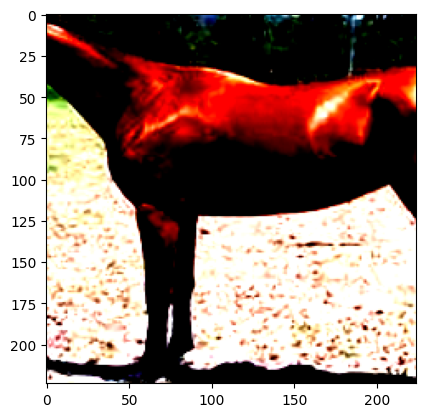

In [34]:
plt.imshow(image.cpu().numpy().transpose((1, 2, 0)))

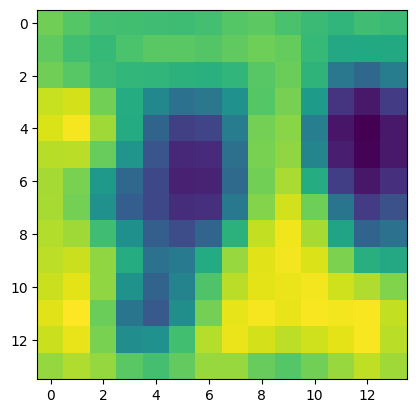

In [35]:
plt.imshow(att.detach().cpu().numpy()[0, 0])

In [22]:
torch.sigmoid(att_outputs).detach().cpu().numpy().shape

(1, 1000)

In [11]:
# @dataclass
# class Metrics:
#     accuracy: float
#     f1_score: float
#     confusion_matrix: np.ndarray


def evaluate_model(
    model: nn.Module, dataloader: DataLoader, device: torch.device
) -> dict[str, Any]:
    model.eval()
    preds_l, labels_l = [], []
    for images, labels in tqdm.tqdm(dataloader, desc="Evaluating"):
        images = images.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            logits = model(images)
        preds_l.extend(logits.argmax(-1).cpu().tolist())
        labels_l.extend(labels.argmax(-1).cpu().tolist())

    return classification_report(labels_l, preds_l, output_dict=True)

In [ ]:
report_train = evaluate_model(model, train_dataloader, device)
report_train

Evaluating: 100%|██████████| 94/94 [00:23<00:00,  4.05it/s]


{'0': {'precision': 0.9971465629053178,
  'recall': 0.9945666235446313,
  'f1-score': 0.9958549222797928,
  'support': 3865.0},
 '1': {'precision': 0.9901547116736991,
  'recall': 0.9948186528497409,
  'f1-score': 0.9924812030075187,
  'support': 2123.0},
 'accuracy': 0.9946559786239145,
 'macro avg': {'precision': 0.9936506372895084,
  'recall': 0.9946926381971861,
  'f1-score': 0.9941680626436558,
  'support': 5988.0},
 'weighted avg': {'precision': 0.994667655062177,
  'recall': 0.9946559786239145,
  'f1-score': 0.9946587956907752,
  'support': 5988.0}}

In [38]:
report_test = evaluate_model(model, test_dataloader, device)
report_test

Evaluating: 100%|██████████| 24/24 [00:43<00:00,  1.80s/it]


{'0': {'precision': 0.9969879518072289,
  'recall': 0.9949899799599199,
  'f1-score': 0.995987963891675,
  'support': 998.0},
 '1': {'precision': 0.9900398406374502,
  'recall': 0.994,
  'f1-score': 0.9920159680638723,
  'support': 500.0},
 'accuracy': 0.9946595460614153,
 'macro avg': {'precision': 0.9935138962223395,
  'recall': 0.99449498997996,
  'f1-score': 0.9940019659777737,
  'support': 1498.0},
 'weighted avg': {'precision': 0.9946688225783308,
  'recall': 0.9946595460614153,
  'f1-score': 0.9946621975940104,
  'support': 1498.0}}

In [ ]:
# @dataclass
# class TestConfig:
#     device: torch.device


# @dataclass
# class TestResult:
#     pass


# def test_model(model: nn.Module, config: TestConfig):
#     model.eval()
#     model.to(config.device)
#     with torch.no_grad():
#         for images, labels in tqdm.tqdm(test_dataloader, desc="Testing"):
#             images = images.to(device)
#             labels = labels.to(device)

#             outputs = model(images)
#             loss = loss_fn(outputs, labels.argmax(axis=1))
#             print(f"Test Loss: {loss.item()}")

## Explanations

In [12]:
def read_image_np(path: str | Path) -> np.ndarray:
    path = Path(path)
    image = PIL.Image.open(path)
    return np.asarray(image)


def show_image_np(image: np.ndarray, ax: plt.Axes | None = None) -> plt.Axes:
    if ax is None:
        fig, ax = plt.subplots()
    ax.imshow(image)
    return ax


def show_image(path: str | Path, ax: plt.Axes | None = None) -> plt.Axes:
    path = Path(path)
    if ax is None:
        fig, ax = plt.subplots()
    show_image_np(read_image_np(path))
    return ax

### LIME

In [13]:
from lime import lime_image
from skimage.segmentation import mark_boundaries

In [84]:
class ClassifierWrapper:
    def __init__(self, model: nn.Module, transform: Any, device: torch.device) -> None:
        self.model = model
        self.transform = transform
        self.device = device

    def __call__(self, images: np.ndarray) -> np.ndarray:
        images = torch.tensor(images).permute(0, 3, 1, 2).to(self.device)
        images = torch.stack([self.transform(image) for image in images]).to(
            self.device
        )
        with torch.no_grad():
            logits = self.model(images)
            probs = torch.softmax(logits, dim=-1)
        return probs.cpu().numpy()


def lime_explain(
    model: nn.Module,
    transform: Any,
    image: np.ndarray,
    top_labels: int = 5,
    hide_color: int = 0,
    num_samples: int = 1000,
) -> lime_image.ImageExplanation:
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(
        image=image,
        classifier_fn=ClassifierWrapper(model, transform, device),
        top_labels=top_labels,
        hide_color=hide_color,
        num_samples=num_samples,
    )
    return explanation

  0%|          | 0/1000 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Pred: 0\nTrue: 0, cane, dog')

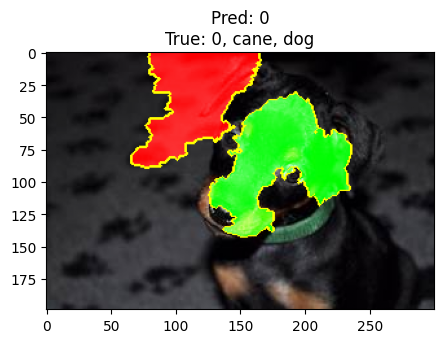

In [85]:
idx = 100

model.eval()

data_entry = train_dataset.data_df.iloc[idx]

lime_explanation = lime_explain(
    model,
    train_dataset.transform,
    read_image_np(train_dataset.data_df.iloc[idx]["path"]),
    num_samples=1000,
)

temp, mask = lime_explanation.get_image_and_mask(
    label=data_entry["label_idx"],
    positive_only=False,
    hide_rest=False,
)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
show_image_np(mark_boundaries(temp, mask), ax=ax)
ax.set_title(
    f"Pred: {lime_explanation.top_labels[0]}\n"
    + f"True: {data_entry['label_idx']}, {data_entry['italian_label'].value}, {data_entry['english_label'].value}"
)

### SHAP

In [53]:
import shap
import shap.maskers

In [81]:
def shap_explain(
    model: nn.Module, img_path: str | Path, output_names: list[str] | None
) -> shap.Explanation:
    img_np = read_image_np(img_path)
    masker_blur = shap.maskers.Image("blur(5,5)", img_np.shape)
    explainer = shap.Explainer(
        ClassifierWrapper(model, train_dataset.transform, device),
        masker_blur,
        output_names=output_names,
    )

    explanation = explainer(img_np[np.newaxis], max_evals=10000, batch_size=50)

    return explanation


def plot_shap_explanation(explanation: shap.Explanation):
    shap.image_plot(
        shap_values=explanation,
        # shap_values=[vals for vals in np.moveaxis(explanation.values, -1, 0)],
        # pixel_values=explanation.data,
        # labels=explanation.output_names,
    )

  0%|          | 0/9998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.87s/it]               


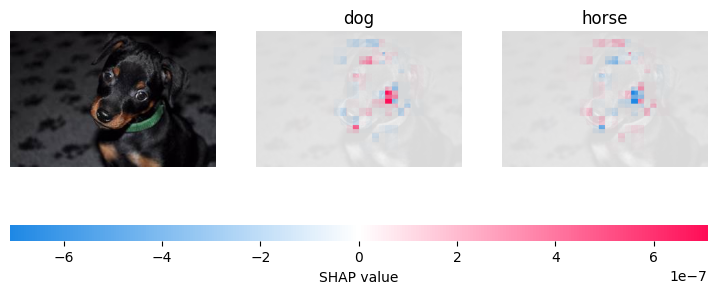

In [ ]:
output_names = (
    train_dataset.data_df.groupby("label_idx")["english_label"]
    .first()
    .sort_values()
    .apply(lambda x: x.value)
    .to_list()
)

idx = 100
shap_explanation = shap_explain(
    model, train_dataset.data_df.iloc[idx]["path"], output_names
)
plot_shap_explanation(shap_explanation)